# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

import warnings
warnings.filterwarnings("ignore")

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

https://habr.com/ru/companies/econtenta/articles/303458/

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
  map_k,  num_users = 0, 0
  for relevant_items, predicted_items in zip(relevant, predicted):
    if len(predicted_items) < k:
      k = len(predicted_items)
    bool_in_relevant = np.isin(predicted_items[:k], relevant_items) #массив из булевых значений, входит ли predicted_item в relevant_items

    #ap_k
    ap_k = 0
    for i in range(k):
      p_k = bool_in_relevant[:i+1].sum() / (i+1)
      ap_k += bool_in_relevant[i] * p_k
    ap_k = ap_k / min(k, len(relevant_items))
    map_k += ap_k
    num_users+=1

  return map_k / num_users


In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for user_id in np.unique(self.ratings['userId']):
          user_preds = self.recommend(user_id) #получаем предсказания для user
          test_preds.append(user_preds)
        test_preds = self.remove_train_items(test_preds,k) #удаление прослушанных треков из рекоммендаций

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    numerator = np.sum(user_vector * ratings, axis = 1)
    denominator = np.sqrt(np.sum(user_vector)) * np.sqrt(np.sum(ratings, axis = 1))
    return numerator / denominator

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = np.sum(user_vector * ratings, axis = 1)
    denominator = np.sum(np.logical_or(user_vector, ratings), axis = 1)
    return numerator / denominator

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #сначала определяем соседей
        similarities = self.similarity(self.R[uid])
        similarities[uid] = 0 #чтобы сам user не стал своим соседом
        vectors_of_neighbours = self.R[similarities > self.alpha]
        similarities_of_neighbours = similarities[similarities > self.alpha]
        similarities_of_neighbours = similarities_of_neighbours.reshape(-1, 1)

        numerator = np.sum(similarities_of_neighbours*vectors_of_neighbours, axis = 0)
        denominator = np.sum(np.abs(similarities_of_neighbours))
        #print(numerator, denominator)
        preds =  numerator / (denominator + 1e-10) #чтобы не было деления на ноль
        return np.argsort(preds)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [ ]:
k = max(test_ratings.groupby('userId').size()) #48
map_k_jaccard = []
map_k_pearsom = []

model_jaccard = User2User(train_ratings, jaccard)
model_pearson = User2User(train_ratings, pearson)


for i in tqdm(range(1,k+1, 3)): #длится 16 минут
    prediction_jaccard = model_jaccard.get_test_recommendations(i)
    map_k_jaccard.append(mapk(test_relevant, prediction_jaccard))
    prediciton_pearson = model_pearson.get_test_recommendations(i)
    map_k_pearsom.append(mapk(test_relevant, prediciton_pearson))

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
map_k_random = []

for i in tqdm(range(1,k+1, 3)):
  prediction_random = np.random.randint(0, len(np.unique(train_ratings['trackId'])), size = (len(np.unique(ratings['userId'])), i))
  map_k_random.append(mapk(test_relevant, prediction_random, i))

  0%|          | 0/16 [00:00<?, ?it/s]

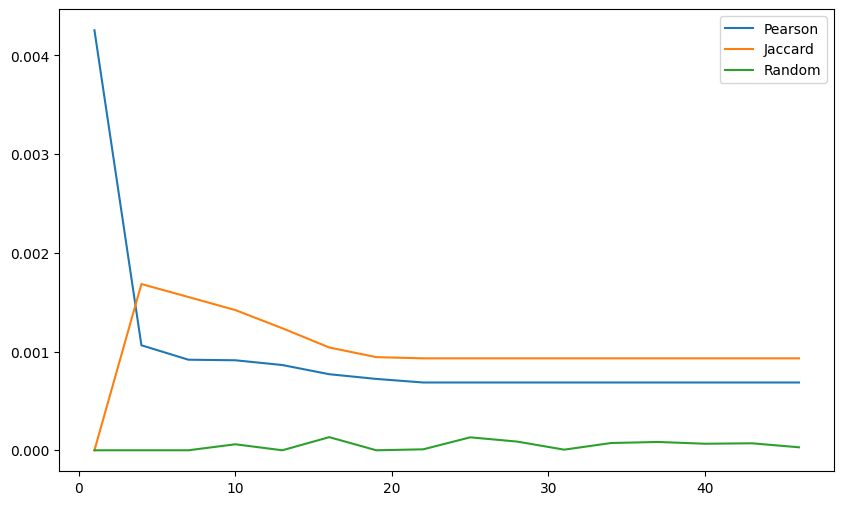

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, k+1, 3), map_k_pearsom, label='Pearson')
plt.plot(np.arange(1, k+1, 3), map_k_jaccard, label='Jaccard')
plt.plot(np.arange(1, k+1, 3), map_k_random, label='Random')
plt.legend()
plt.show()

__Выводы сделаны ниже, так как в задании 6 график построен для всех k__ (так как быстрее считается, посчитано для всех k)

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))
        #меняем на csr_matrix
        self.R = scs.coo_array((np.ones(len(self.ratings), dtype=int), (self.ratings.userId, self.ratings.trackId)), shape=(self.n_users, self.n_items)).tocsr()

    def recommend(self, uid: int):
        raise NotImplementedError

    def remove_train_items(self, preds: List[np.ndarray], k: int):
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in np.unique(self.ratings['userId']):
            user_preds = self.recommend(user_id)
            test_preds.append(user_preds)
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds


In [ ]:
def pearson(ratings:scs.csr_matrix, user_vector:scs.csr_matrix) -> np.ndarray:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    numerator = np.sum(user_vector * ratings, axis = 1)
    denominator = np.sqrt(np.sum(user_vector)) * np.sqrt(np.sum(ratings, axis = 1))
    return numerator / denominator

def jaccard(ratings: scs.csr_matrix, user_vector: scs.csr_matrix) -> np.array:
    numerator = np.sum(user_vector * ratings, axis = 1)
    denominator = np.sum(ratings - user_vector * ratings + user_vector.toarray().squeeze(), axis = 1)
    return numerator / denominator


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #сначала определяем соседей
        similarities = self.similarity(self.R[[uid]])
        similarities[uid] = 0 #чтобы сам user не стал своим соседом
        vectors_of_neighbours = self.R[similarities > self.alpha]
        similarities_of_neighbours = similarities[similarities > self.alpha]
        similarities_of_neighbours = similarities_of_neighbours.reshape(-1, 1)

        numerator = np.sum(similarities_of_neighbours*vectors_of_neighbours, axis = 0)
        denominator = np.sum(np.abs(similarities_of_neighbours))
        #print(numerator, denominator)
        preds =  numerator / (denominator + 1e-10) #чтобы не было деления на ноль
        return np.argsort(preds)[::-1]

In [ ]:
k = max(test_ratings.groupby('userId').size()) #48
map_k_jaccard = []
map_k_pearsom = []

model_jaccard = User2User(train_ratings, jaccard)
model_pearson = User2User(train_ratings, pearson)


for i in tqdm(range(1,k+1)): #длится 5 минут
    prediction_jaccard = model_jaccard.get_test_recommendations(i)
    map_k_jaccard.append(mapk(test_relevant, prediction_jaccard))
    prediciton_pearson = model_pearson.get_test_recommendations(i)
    map_k_pearsom.append(mapk(test_relevant, prediciton_pearson))

  0%|          | 0/48 [00:00<?, ?it/s]

__Результат__: если раньше на одну итерацию уходила минута, то теперь уходит 20 секунд

In [ ]:
map_k_random = []

for i in tqdm(range(1,k+1)):
  prediction_random = np.random.randint(0, len(np.unique(train_ratings['trackId'])), size = (len(np.unique(ratings['userId'])), i))
  map_k_random.append(mapk(test_relevant, prediction_random, i))

  0%|          | 0/48 [00:00<?, ?it/s]

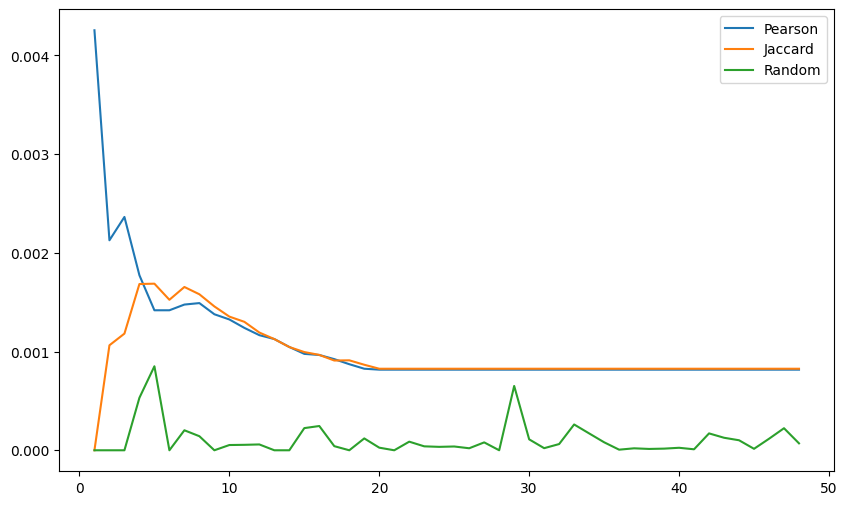

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, k+1), map_k_pearsom, label='Pearson')
plt.plot(np.arange(1, k+1), map_k_jaccard, label='Jaccard')
plt.plot(np.arange(1, k+1), map_k_random, label='Random')
plt.legend()
plt.show()

__Вывод__:
- Корреляция Пирсона в качестве функции похожести показывает наилучшее значение MAP@k, и оно достигается при малых значениях k.
- Для всех k больше 10 обе функции похожести дают примерно одинаковые значения MAP@k
- Предсказания случайного алгоритма значительно уступают предсказаниям на основе функций похожести корреляции Пирсона и меры Жаккара для любого k

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
model = User2User(train_ratings, pearson)

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
32,We Made You,['Eminem']
220,I Was Made For Lovin' You,['Kiss']
241,In Da Club,['50 Cent']
243,P.I.M.P.,['50 Cent']
310,Drop It Like It's Hot,"['Snoop Dogg', 'Pharrell Williams']"
418,Without Me,['Eminem']
419,The Real Slim Shady,['Eminem']
420,Mockingbird,['Eminem']
421,Lose Yourself,['Eminem']
422,Stan,"['Eminem', 'Dido']"


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
24500,Way Down We Go,['KALEO']
11493,The Show Must Go On,['Queen']
4032,Bring Me To Life,['Evanescence']
33436,Believer,['Imagine Dragons']
2555,Californication,['Red Hot Chili Peppers']
23429,Stressed Out,['twenty one pilots']
18459,Take Me To Church,['Hozier']
40209,Выхода нет,['Сплин']
7780,ИСКАЛА,['Земфира']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
60759,Fendi,['Rakhim']
61131,ICE,['MORGENSHTERN']
61140,911,['Элджей']
61582,Whoopty,['CJ']
61712,Не раз убивало,"['Витя АК', 'MORGENSHTERN']"
62017,El Problema,"['MORGENSHTERN', 'Тимати']"
62418,Снова я напиваюсь,['SLAVA MARLOW']
62764,Rolls Royce,"['Джиган', 'Тимати', 'ЕГОР КРИД']"
62794,Быстро,"['SLAVA MARLOW', 'MORGENSHTERN']"
62796,По глазам,['SLAVA MARLOW']


__Вывод__: предсказания довольно плохие

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Вспомните формулы обновления и поясните их:

SGD
https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

ALS
https://habr.com/ru/companies/prequel/articles/567648/

**SGD:**

$$
p_{u,j+1}  = p_{u, j} + \eta ( q_{i, j} \cdot e_{ui} -\lambda \cdot p_{u, j} )
$$
$$
q_{i,j+1}  = q_{i, j} + \eta ( p_{u, j} \cdot e_{ui} -\lambda \cdot q_{i, j} )
$$
$$
e_{ui} = r_{ui} - q_{i}^Tp_{u}
$$


**ALS:**

$$
P = RQ( Q^TQ + \lambda I)^{-1}
$$
$$
Q = RP (P^TP + \lambda I)^{-1}
$$



**Задание 8 (2 балла).** А теперь реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                p_ind = np.random.randint(0, self.n_users) #индекс рандомного user
                q_ind = np.random.randint(0, self.n_items) #индекс рандомного item

                #обновление
                e = self.R[p_ind, q_ind] - np.sum(self.P[p_ind] * self.Q[q_ind])
                self.P[p_ind] = self.P[p_ind] + self.lr * (self.Q[q_ind] * e - self.lamb * self.P[p_ind])
                self.Q[q_ind] = self.Q[q_ind] + self.lr * (self.P[p_ind] * e - self.lamb * self.Q[q_ind])

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                matrix = self.Q.T @ self.Q + self.lamb * np.eye(self.dim)
                self.P = self.R @ self.Q @np.linalg.inv(matrix)
                matrix = self.P.T @ self.P + self.lamb * np.eye(self.dim)
                self.Q = self.R.T @ self.P @ np.linalg.inv(matrix)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
params = [
    {'dim': 32, 'k': 5, 'mode': 'sgd'},
    {'dim': 64, 'k': 5, 'mode': 'sgd'},
    {'dim': 128, 'k': 5, 'mode': 'sgd'},
    {'dim': 256, 'k': 5, 'mode': 'sgd'},
    {'dim': 512, 'k': 5, 'mode': 'sgd'},
    {'dim': 64, 'k': 10, 'mode': 'sgd'},
    {'dim': 128, 'k': 10, 'mode': 'sgd'},
    {'dim': 256, 'k': 10, 'mode': 'sgd'},
    {'dim': 512, 'k': 10, 'mode': 'sgd'},
    {'dim': 64, 'k': 15, 'mode': 'sgd'},
    {'dim': 128, 'k': 15, 'mode': 'sgd'},
    {'dim': 256, 'k': 15, 'mode': 'sgd'},
    {'dim': 512, 'k': 15, 'mode': 'sgd'},
    {'dim': 64, 'k': 20, 'mode': 'sgd'},
    {'dim': 128, 'k': 20, 'mode': 'sgd'},
    {'dim': 256, 'k': 20, 'mode': 'sgd'},
    {'dim': 512, 'k': 20, 'mode': 'sgd'},
]

metric_sgd = 0.0
params_sgd = None
metrics_k5 = []
metrics_k10 = []
metrics_k15 = []
metrics_k20 = []
dim_k5 = []
dim_k10 = []
dim_k15 = []
dim_k20 = []

for d in tqdm(params):
    model_sgd = HiddenVars(train_ratings, mode = 'sgd', dim = d['dim'])
    model_sgd.fit(num_iters=5)
    recommendations = model_sgd.get_test_recommendations(d['k'])
    score = mapk(test_relevant, recommendations, d['k'])
    if d['k'] == 5:
      dim_k5.append(d['dim'])
      metrics_k5.append(score)
    elif d['k'] == 10:
      dim_k10.append(d['dim'])
      metrics_k10.append(score)
    elif d['k'] == 15:
      dim_k15.append(d['dim'])
      metrics_k15.append(score)
    elif d['k'] == 20:
      dim_k20.append(d['dim'])
      metrics_k20.append(score)
    if score > metric_sgd:
        metric_sgd = score
        params_sgd = d

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

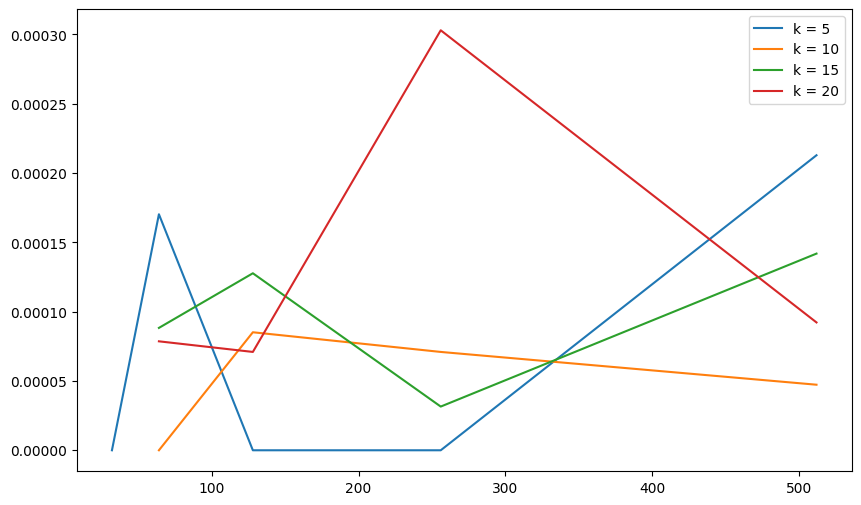

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dim_k5, metrics_k5, label='k = 5')
plt.plot(dim_k10, metrics_k10, label='k = 10')
plt.plot(dim_k15, metrics_k15, label='k = 15')
plt.plot(dim_k20, metrics_k20, label='k = 20')
plt.legend()
plt.show()

In [ ]:
print(f'Лучший результат: {metric_sgd}')
print(f'Параметры: {params_sgd}')

Лучший результат: 0.0003028959810874705
Параметры: {'dim': 256, 'k': 20, 'mode': 'sgd'}


In [ ]:
params = [
    {'dim': 762, 'k': 10, 'mode': 'sgd'},
    {'dim': 900, 'k': 10, 'mode': 'sgd'},
    {'dim': 1024, 'k': 10, 'mode': 'sgd'},
]

for d in tqdm(params):
    model_sgd = HiddenVars(train_ratings, mode = 'sgd', dim = d['dim'])
    model_sgd.fit(num_iters=5)
    recommendations = model_sgd.get_test_recommendations(d['k'])
    score = mapk(test_relevant, recommendations, d['k'])
    dim_k10.append(d['dim'])
    metrics_k10.append(score)

    if score > metric_sgd:
        metric_sgd = score
        params_sgd = d

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

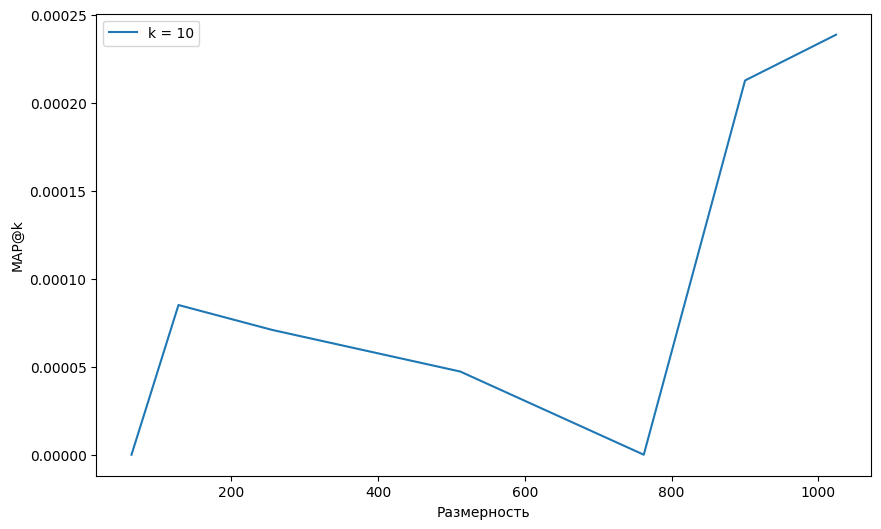

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dim_k10, metrics_k10, label='k = 10')
plt.xlabel('Размерность')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

In [ ]:
print(f'Лучший результат: {metric_sgd}')
print(f'Параметры: {params_sgd}')

Лучший результат: 0.0003028959810874705
Параметры: {'dim': 256, 'k': 20, 'mode': 'sgd'}


In [ ]:
np.random.seed(42)
params = [
    {'dim': 1024, 'k': 5, 'mode': 'sgd'},
    {'dim': 1524, 'k': 5, 'mode': 'sgd'},
]


for d in tqdm(params):
    model_sgd = HiddenVars(train_ratings, mode = 'sgd', dim = d['dim'])
    model_sgd.fit(num_iters=5)
    recommendations = model_sgd.get_test_recommendations(d['k'])
    score = mapk(test_relevant, recommendations, d['k'])
    dim_k5.append(d['dim'])
    metrics_k5.append(score)
    if score > metric_sgd:
        metric_sgd = score
        params_sgd = d

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

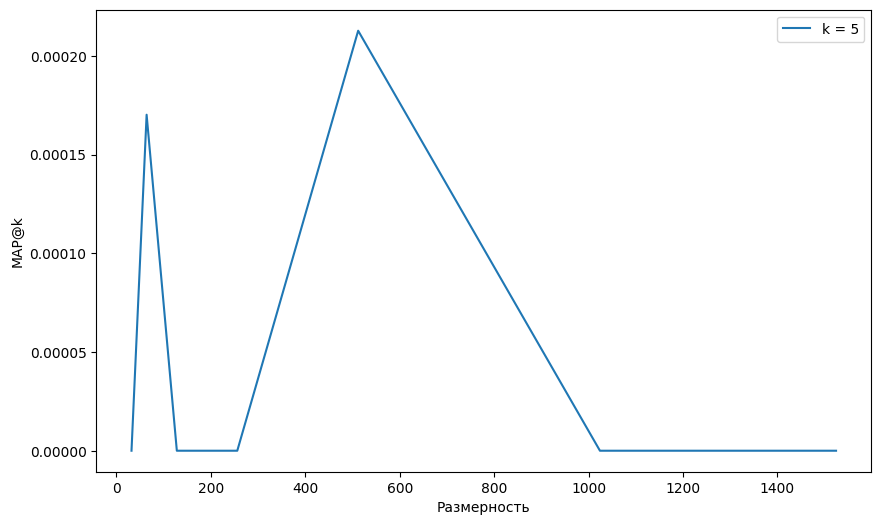

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dim_k5, metrics_k5, label='k = 5')
plt.xlabel('Размерность')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

In [ ]:
print(f'Лучший результат: {metric_sgd}')
print(f'Параметры: {params_sgd}')

Лучший результат: 0.0003028959810874705
Параметры: {'dim': 256, 'k': 20, 'mode': 'sgd'}


In [ ]:
np.random.seed(42)
params = [
    {'dim': 32, 'k': 5, 'mode': 'als'},
    {'dim': 64, 'k': 5, 'mode': 'als'},
    {'dim': 128, 'k': 5, 'mode': 'als'},
    {'dim': 256, 'k': 5, 'mode': 'als'},
    {'dim': 512, 'k': 5, 'mode': 'als'},
    {'dim': 64, 'k': 10, 'mode': 'als'},
    {'dim': 128, 'k': 10, 'mode': 'als'},
    {'dim': 256, 'k': 10, 'mode': 'als'},
    {'dim': 512, 'k': 10, 'mode': 'als'},
    {'dim': 64, 'k': 15, 'mode': 'als'},
    {'dim': 128, 'k': 15, 'mode': 'als'},
    {'dim': 256, 'k': 15, 'mode': 'als'},
    {'dim': 512, 'k': 15, 'mode': 'als'},
    {'dim': 64, 'k': 20, 'mode': 'als'},
    {'dim': 128, 'k': 20, 'mode': 'als'},
    {'dim': 256, 'k': 20, 'mode': 'als'},
    {'dim': 512, 'k': 20, 'mode': 'als'},
]

metric_als = 0.0
params_als = None
metrics_k5 = []
metrics_k10 = []
metrics_k15 = []
metrics_k20 = []
dim_k5 = []
dim_k10 = []
dim_k15 = []
dim_k20 = []

for d in tqdm(params):
    model_als = HiddenVars(train_ratings, mode = 'als', dim = d['dim'])
    model_als.fit(num_iters=5)
    recommendations = model_als.get_test_recommendations(d['k'])
    score = mapk(test_relevant, recommendations, d['k'])
    if d['k'] == 5:
      dim_k5.append(d['dim'])
      metrics_k5.append(score)
    elif d['k'] == 10:
      dim_k10.append(d['dim'])
      metrics_k10.append(score)
    elif d['k'] == 15:
      dim_k15.append(d['dim'])
      metrics_k15.append(score)
    elif d['k'] == 20:
      dim_k20.append(d['dim'])
      metrics_k20.append(score)
    if score > metric_als:
        metric_als = score
        params_als = d

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

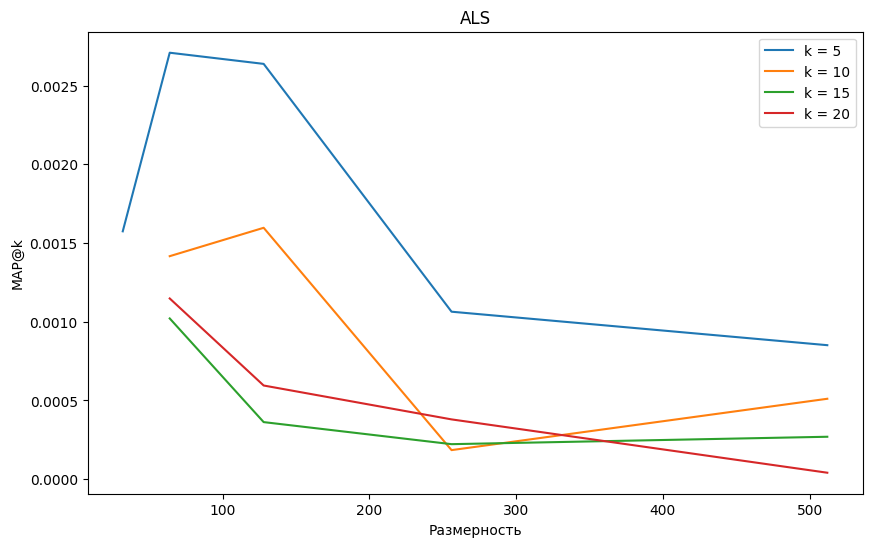

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dim_k5, metrics_k5, label='k = 5')
plt.plot(dim_k10, metrics_k10, label='k = 10')
plt.plot(dim_k15, metrics_k15, label='k = 15')
plt.plot(dim_k20, metrics_k20, label='k = 20')
plt.xlabel('Размерность')
plt.ylabel('MAP@k')
plt.title('ALS')
plt.legend()
plt.show()

In [ ]:
print(f'Лучший результат: {metric_als}')
print(f'Параметры: {params_als}')

Лучший результат: 0.002709219858156028
Параметры: {'dim': 64, 'k': 5, 'mode': 'als'}


In [ ]:
np.random.seed(42)
params = [
    {'dim': 64, 'k': 1, 'mode': 'als'},
    {'dim': 128, 'k': 1, 'mode': 'als'},
    {'dim': 512, 'k': 1, 'mode': 'als'},
]

dim_k1 = []
metrics_k1 = []

for d in tqdm(params):
    model_als = HiddenVars(train_ratings, mode = 'als', dim = d['dim'])
    model_als.fit(num_iters=5)
    recommendations = model_als.get_test_recommendations(d['k'])
    score = mapk(test_relevant, recommendations, d['k'])
    dim_k1.append(d['dim'])
    metrics_k1.append(score)

    if score > metric_sgd:
        metric_sgd = score
        params_sgd = d

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

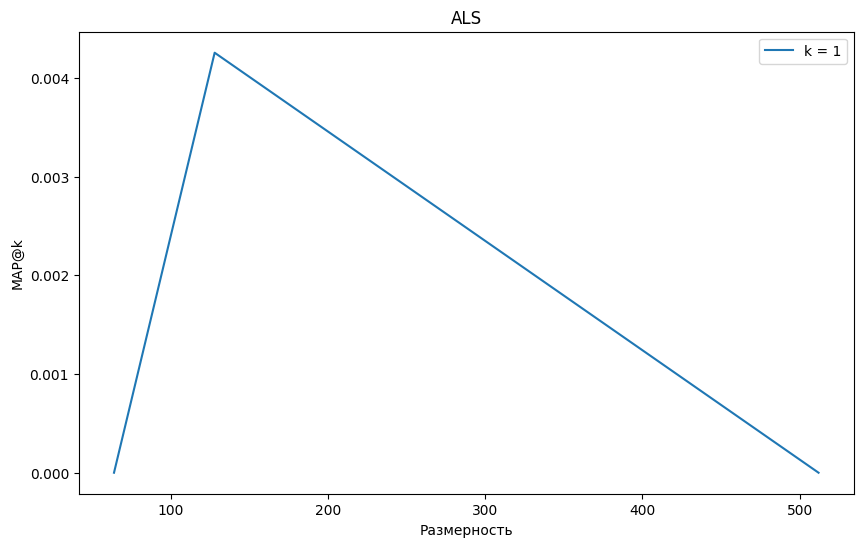

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dim_k1, metrics_k1, label='k = 1')
plt.xlabel('Размерность')
plt.ylabel('MAP@k')
plt.title('ALS')
plt.legend()
plt.show()

In [ ]:
print(f'Лучший результат: {metric_als}')
print(f'Параметры: {params_als}')

Лучший результат: 0.002709219858156028
Параметры: {'dim': 64, 'k': 5, 'mode': 'als'}


Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
model = HiddenVars(train_ratings, mode = 'als', dim = 64)
model.fit(num_iters=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:5]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.796118
5153,Stormbringer,['Deep Purple'],0.769459
16637,Zodiac,['Zodiac'],0.769459
9689,Bicycle Race,['Queen'],0.769459
